**IMPORT LIBRARY DAN DATASET**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
# install kaggle package
!pip install -q kaggle 

In [3]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"afifxxiv","key":"8a5bd89b9d50a3d7cf0c65d6043bfd5a"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
# Download dataset
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 16.1MB/s]


In [6]:
# unzip
!mkdir data
!unzip -qq titanic.zip -d data
!ls data

gender_submission.csv  test.csv  train.csv


Pada cell dibawah ini dilakukan import dataset 

In [7]:
data_train = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Cell dibawah ini untuk melihat rangkuman dataset

In [8]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Cell dibawah ini digunakan untuk melakukan cek pada NaN values di dalam dataset

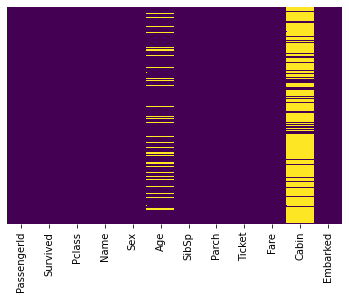

In [9]:
sns.heatmap(data_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Pada cell dibawah berfungsi untuk menghapus data cabin karena banyak NaN values dan pada kolom age terdapat NaN values dengan nilai median.

In [10]:
data_train.drop(['Cabin'],axis=1,inplace=True)
data_train['Age'] = data_train['Age'].fillna((data_train['Age'].median()))

Cell dibawah digunakan untuk mengecek apakah masih terdapat NaN values.

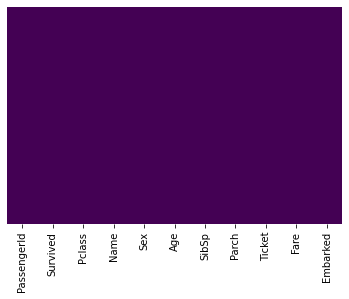

In [11]:
sns.heatmap(data_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Pada cell dibawah berfungsi untuk menghilangkan value-value yang terlalu jauh.

In [12]:
Q1 = data_train.quantile(0.25)
Q3 = data_train.quantile(0.75)
IQR=Q3-Q1
data_train=data_train[~((data_train<(Q1-1.5*IQR))|(data_train>(Q3+1.5*IQR))).any(axis=1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  after removing the cwd from sys.path.


**Univariate Analysis**

Cell code dibawah ini digunakan sebagai num dengan object kolom

In [13]:
train_num = ['Age','SibSp','Fare']
train_cat = ['Survived','Pclass','Sex','Ticket','Embarked']

Pada cell code dibawah dilakukan Univariate EDA pada kolom-kolom object

   jumlah sampel  persentase
0            404        70.0
1            173        30.0


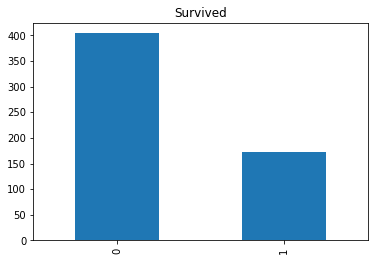

   jumlah sampel  persentase
3            373        64.6
2            121        21.0
1             83        14.4


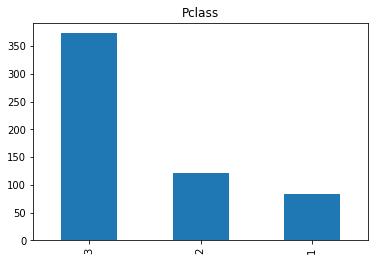

        jumlah sampel  persentase
male              434        75.2
female            143        24.8


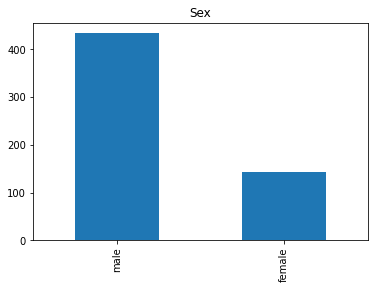

        jumlah sampel  persentase
1601                7         1.2
LINE                4         0.7
371110              3         0.5
239853              3         0.5
250647              2         0.3
...               ...         ...
226593              1         0.2
9234                1         0.2
19988               1         0.2
2693                1         0.2
370376              1         0.2

[527 rows x 2 columns]


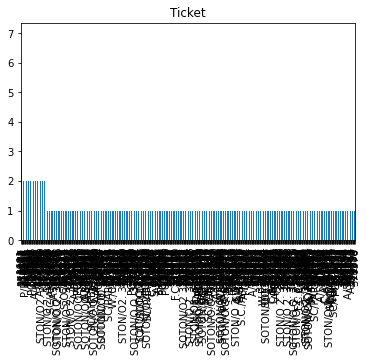

   jumlah sampel  persentase
S            433        75.0
C             80        13.9
Q             64        11.1


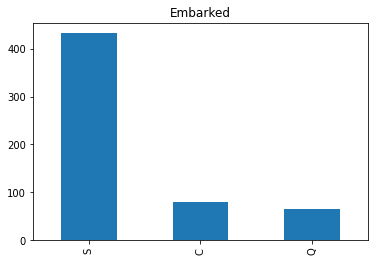

In [14]:
for i in range(len(train_cat)):
    feature = train_cat[i]
    count = data_train[feature].value_counts()
    percent = 100*data_train[feature].value_counts(normalize=True)
    df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
    print(df)
    count.plot(kind='bar', title=feature)
    plt.show()

**Multivariate Analysis**

Pada cell code di bawah berfungsi untuk mengecek pada Multivariate EDA dengan heatmap

Text(0.5, 1.0, 'Correlation Matrix')

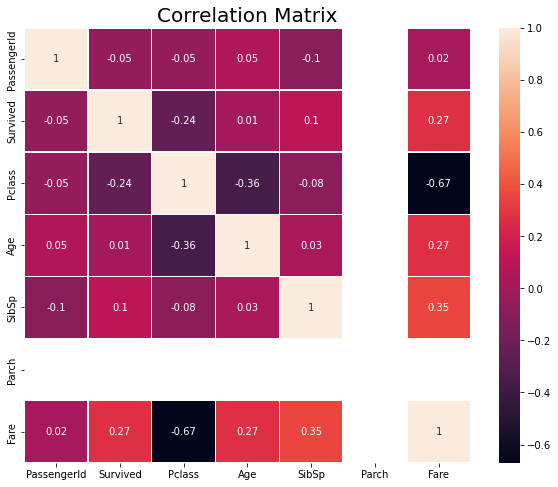

In [15]:
plt.figure(figsize=(10, 8))
correlation_matrix = data_train.corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True,linewidths=0.5 )
plt.title("Correlation Matrix", size=20)

Cell code di bawah berfungsi menghapus Pclass dan Parch karena memiliki korelasi yang rendah terhadap suvivability

In [16]:
data_train.drop(['Pclass','Parch'],axis=1,inplace=True)
data_train.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Ticket,Fare,Embarked
0,1,0,"Braund, Mr. Owen Harris",male,22.0,1,A/5 21171,7.2500,S
2,3,1,"Heikkinen, Miss. Laina",female,26.0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,113803,53.1000,S
4,5,0,"Allen, Mr. William Henry",male,35.0,0,373450,8.0500,S
5,6,0,"Moran, Mr. James",male,28.0,0,330877,8.4583,Q


**Data Preparation**

Cell code dibawah dilakukan get_dummies pada kolom sex dan embark

In [17]:
sex = pd.get_dummies(data_train['Sex'])
embark = pd.get_dummies(data_train['Embarked'])

Pada cell code dibawah, dilakukan drop/menghapus kolom yang tidak relevan dan meng-concat get_dummies dari sex dan embarked sebelumnya

In [18]:
data_train.drop(['PassengerId','Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
data_train = pd.concat([data_train,sex,embark],axis=1)
data_train.head()

,Survived,Age,SibSp,Fare,female,male,C,Q,S
0,0,22.0,1,7.2500,0,1,0,0,1
2,1,26.0,0,7.9250,1,0,0,0,1
3,1,35.0,1,53.1000,1,0,0,0,1
4,0,35.0,0,8.0500,0,1,0,0,1
5,0,28.0,0,8.4583,0,1,0,1,0


Cell code dibawah berfungsi untuk men-split data train.

In [19]:
from sklearn.model_selection import train_test_split
 
X = data_train.drop(["Survived"],axis =1)
y = data_train["Survived"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

Pada cell code di bawah dilakukan standardscaler pada x train dan x valid

In [20]:
from sklearn.preprocessing import StandardScaler
train_num = ['Age','SibSp','Fare']
scaler = StandardScaler()
scaler.fit(X_train[train_num])
scaler.fit(X_valid[train_num])
X_train[train_num] = scaler.transform(X_train.loc[:, train_num])
X_valid[train_num] = scaler.transform(X_valid.loc[:, train_num])
X_train.head()

,Age,SibSp,Fare,female,male,C,Q,S
376,-0.896989,-0.464294,-0.657139,1,0,0,0,1
108,1.022102,-0.464294,-0.607451,0,1,0,0,1
800,0.542329,-0.464294,-0.214737,0,1,0,0,1
154,-0.177330,-0.464294,-0.652330,0,1,0,0,1
398,-0.777045,-0.464294,-0.407085,0,1,0,0,1


**Model Development**

**XGBClassifier**

Pada cell code di bawah digunakan untuk mendefinisikan paramater XGBClassifier

In [21]:
model_XGBClassifier = XGBClassifier()
model_XGBClassifier.fit(X_train, y_train,
          verbose=False)

preds_XGBClassifier = model_XGBClassifier.predict(X_valid)

Cell code di bawah untuk menghitung akurasi, presisi, recall, dan F1 score model XGBClassifier

In [22]:
accuracy_XGBClassifier=accuracy_score(y_valid,preds_XGBClassifier)
print("XGBClassifier accuracy value: {:.2f}".format(accuracy_XGBClassifier))
print('XGBClassifier Precision: %.3f' % precision_score(y_valid,preds_XGBClassifier))
print('XGBClassifier Recall: %.3f' % recall_score(y_valid,preds_XGBClassifier))
print('XGBClassifier F1 Score: %.3f' % f1_score(y_valid,preds_XGBClassifier))

XGBClassifier accuracy value: 0.76
XGBClassifier Precision: 0.594
XGBClassifier Recall: 0.559
XGBClassifier F1 Score: 0.576


**Preprocessing Test Data**

Pada cell di bawah dilakukan drop pada kolom yang telah didrop pada data train

In [23]:
X_test=data_test.drop(['Cabin','Parch','PassengerId','Name','Ticket','Pclass'],axis =1)
test_num = ['Age','SibSp','Fare']
scaler = StandardScaler()
scaler.fit(X_test[train_num])
X_test[train_num] = scaler.transform(X_test.loc[:, test_num])

Pada cell code dibawah dilakukan get_dummies pada kolom sex dan embark dan dilakukan juga concat pada dataframe test

In [24]:
sex = pd.get_dummies(X_test['Sex'])
embark = pd.get_dummies(X_test['Embarked'])
X_test=X_test.drop(['Sex','Embarked'],axis =1)
X_test = pd.concat([X_test,sex,embark],axis=1)

In [25]:
X_test.head()

,Age,SibSp,Fare,female,male,C,Q,S
0,0.298549,-0.499470,-0.497811,0,1,0,1,0
1,1.181328,0.616992,-0.512660,1,0,0,0,1
2,2.240662,-0.499470,-0.464532,0,1,0,1,0
3,-0.231118,-0.499470,-0.482888,0,1,0,0,1
4,-0.584229,0.616992,-0.417971,1,0,0,0,1


Pada cell code di bawah dilakukan prediksi dari dataset test menggunakan model XGBClassifier

In [26]:
predictions=model_XGBClassifier.predict(X_test)

In [27]:
output = pd.DataFrame({'PassengerId': data_test.PassengerId,
                       'Survived': predictions})
output.to_csv('submission.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
